In [ ]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.filters import gaussian_filter1d
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
from matplotlib import colors

%matplotlib inline
plt.rcParams.update({'font.size': 20})

from sklearn.feature_extraction.image import grid_to_graph
from mpl_toolkits.axes_grid1 import ImageGrid
import json
from matplotlib.ticker import FuncFormatter

import nibabel as nib

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
import itertools
import random
import matplotlib as mpl
from matplotlib.pyplot import cm

from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression
import matplotlib.patches as patches

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

from scipy.fftpack import fft,fftshift,ifft
from scipy import signal
import pickle
from tqdm import tqdm
from shutil import copyfile
import cv2
from scipy.ndimage.morphology import binary_erosion
from scipy.ndimage.morphology import binary_dilation

In [2]:
### Load Luke Mean ###
luke_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/20210310_luke_exp_thresh.nii"
res_luke_mean = (0.65,0.65,1)
luke_mean = np.asarray(nib.load(luke_path).get_data().squeeze(), dtype='float32')
luke_mean = luke_mean[:,:,::-1] #flipz
luke_mean = ants.from_numpy(luke_mean)
luke_mean.set_spacing(res_luke_mean)
luke_mean_lowres =  ants.resample_image(luke_mean,(256,128,49),use_voxels=True)

### Load JFRC2018 ###
fixed_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/JRC2018_FEMALE_38um_iso_16bit.nii"
res_JRC2018 = (0.38, 0.38, 0.38)
fixed = np.asarray(nib.load(fixed_path).get_data().squeeze(), dtype='float32')
fixed = ants.from_numpy(fixed)
fixed.set_spacing(res_JRC2018)
fixed_lowres = ants.resample_image(fixed,(2,2,2),use_voxels=False)

### Load Atlas ###
atlas_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/jfrc_2018_rois_improve_reorient_transformed.nii"
atlas = np.asarray(nib.load(atlas_path).get_data().squeeze(), dtype='float32')
atlas = ants.from_numpy(atlas)
atlas.set_spacing((.76,.76,.76))
atlas = ants.resample_image(atlas,(2,2,2),use_voxels=False)

In [3]:
### Load supervoxel labels ###
n_clusters = 2000
labels_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201129_super_slices/cluster_labels.npy'
cluster_model_labels = np.load(labels_file)

In [4]:
### Load GLM output
main_dir = f'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210309_inst_uniq_glm_state_sub'

### this is what I initially warped into FDA
#main_dir = f'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210309_inst_uniq_glm_state_sub'

all_scores = []
for z in range(9,49-9):
    file = [os.path.join(main_dir, i) for i in os.listdir(main_dir) if f'Z{z}.' in i][0]
    with open(file, 'rb') as handle:
        scores = pickle.load(handle)
    all_scores.append(scores)

In [5]:
scores1='scores_all'
uniques = ['scores_ypos_unique', 'scores_zpos_unique', 'scores_zneg_unique']
maps = {}

for unique in uniques:
    all_colored_by_betas = []
    for z in range(9,49-9):
        colored_by_betas = np.zeros(256*128)
        for cluster_num in range(len(np.unique(cluster_model_labels[z]))):
            cluster_indicies = np.where(cluster_model_labels[z]==cluster_num)[0]
            colored_by_betas[cluster_indicies] = all_scores[z-9][scores1][cluster_num] - all_scores[z-9][unique][cluster_num]

            if len(cluster_indicies) > 100:
                colored_by_betas[cluster_indicies] = 0
            if colored_by_betas[cluster_indicies][0] == 1:
                colored_by_betas[cluster_indicies] = 0
        colored_by_betas = colored_by_betas.reshape(256,128)
        all_colored_by_betas.append(colored_by_betas)
    all_colored_by_betas = np.asarray(all_colored_by_betas)
    maps[unique] = all_colored_by_betas

In [6]:
############################################
### Put into plotting format with colors ###
############################################

slices = []
for z in range(49-18):
    colors1 = maps['scores_zneg_unique'][z,:,:].T
    colors2 = maps['scores_zpos_unique'][z,:,:].T
    colors3 = maps['scores_ypos_unique'][z,:,:].T
    to_plot = np.stack((colors1,colors2,colors3),axis=2)
    slices.append(to_plot)
slices = np.asarray(slices)
slices = np.swapaxes(slices, 1,2)
# func = np.swapaxes(slices, 0, 2)
# func.shape

# res_LUKE = (2.6, 2.6, 5, 1)
# moving = ants.from_numpy(func[:,:,::-1,:])
# moving.set_spacing(res_LUKE)

In [38]:
### SINGLES ###
uniques = ['scores_ypos', 'scores_zpos', 'scores_zneg']
maps = {}

for unique in uniques:
    all_colored_by_betas = []
    for z in range(9,49-9):
        colored_by_betas = np.zeros(256*128)
        for cluster_num in range(len(np.unique(cluster_model_labels[z]))):
            cluster_indicies = np.where(cluster_model_labels[z]==cluster_num)[0]
            colored_by_betas[cluster_indicies] =all_scores[z-9][unique][cluster_num]

            if len(cluster_indicies) > 100:
                colored_by_betas[cluster_indicies] = 0
            if colored_by_betas[cluster_indicies][0] == 1:
                colored_by_betas[cluster_indicies] = 0
        colored_by_betas = colored_by_betas.reshape(256,128)
        all_colored_by_betas.append(colored_by_betas)
    all_colored_by_betas = np.asarray(all_colored_by_betas)
    maps[unique] = all_colored_by_betas
    
############################################
### Put into plotting format with colors ###
############################################

slices = []
for z in range(49-18):
    colors1 = maps['scores_zneg'][z,:,:].T
    colors2 = maps['scores_zpos'][z,:,:].T
    colors3 = maps['scores_ypos'][z,:,:].T
    to_plot = np.stack((colors1,colors2,colors3),axis=2)
    slices.append(to_plot)
slices = np.asarray(slices)
slices = np.swapaxes(slices, 1,2)

In [7]:
pad = np.zeros((9,256,128,3))
all_colored_by_betas_full = np.concatenate((pad,slices,pad))
all_colored_by_betas_full = np.moveaxis(all_colored_by_betas_full,0,2)
all_colored_by_betas_full.shape

(256, 128, 49, 3)

In [8]:
moving = ants.from_numpy(all_colored_by_betas_full[:,:,::-1,:])
moving.set_spacing((2.6076, 2.6154, 5.3125,1)) ### matching this to the slightly off luke mean

In [9]:
out = ants.registration(fixed_lowres, luke_mean_lowres, type_of_transform='Affine')

In [10]:
maps_voxel_res = ants.apply_transforms(fixed_lowres, moving, out['fwdtransforms'][0], imagetype=3, interpolator='nearestNeighbor')

In [11]:
corr_map = maps_voxel_res.numpy()

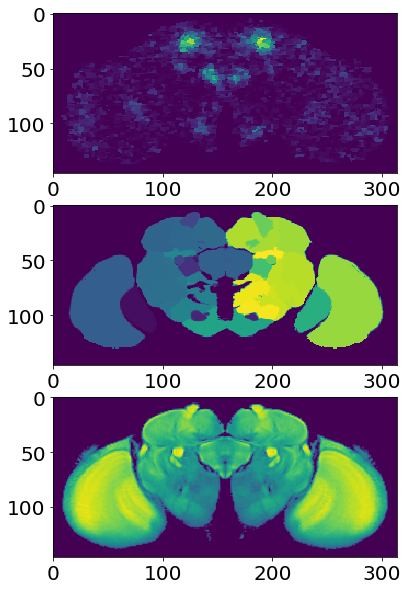

In [12]:
z=50
plt.figure(figsize=(10,10))
plt.subplot(311)
plt.imshow(corr_map[:,:,z,2].T)
plt.subplot(312)
plt.imshow(atlas[:,:,z].T)
plt.subplot(313)
plt.imshow(out['warpedmovout'][:,:,z].T)

In [14]:
corr_map.shape

(314, 146, 91, 3)

In [15]:
cluster_dir = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20221109_cluster_pca/"
save_file = os.path.join(cluster_dir, "20221122_unique_glm")
np.save(save_file, corr_map)

(-0.5, 313.5, 145.5, -0.5)

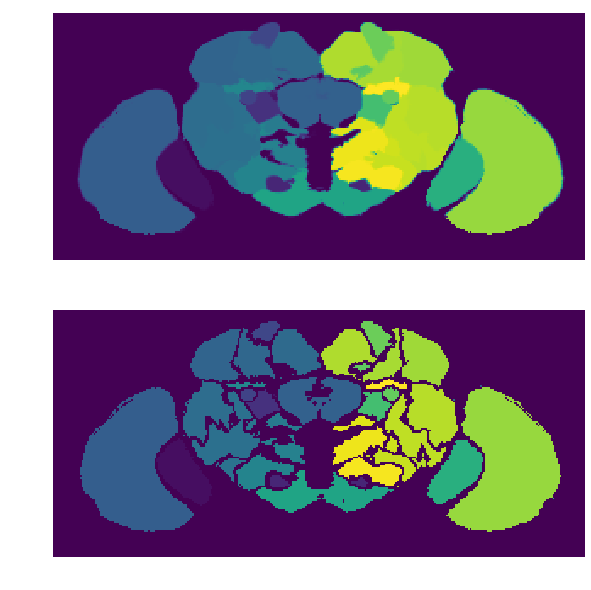

In [13]:
atlas = atlas.numpy()
atlas_int = np.rint(atlas)
atlas_clean = np.copy(atlas_int)
diff_atlas = atlas_int - atlas
thresh = 0.001
atlas_clean[np.where(np.abs(diff_atlas)>thresh)] = 0

plt.figure(figsize=(10,10))
plt.subplot(211)
plt.imshow(atlas[:,:,50].T)
plt.axis('off')

plt.subplot(212)
plt.imshow(atlas_clean[:,:,50].T)
plt.axis('off')

In [14]:
####################################
### FOR SINGLE MAP (ie, not RGB) ###
####################################

def plot_grouped_roi_image(rois,plot=True):
    roi_data = []
    roi_contours = []

    left_edges = []
    right_edges = []
    bottom_edges = []
    top_edges = []

    for roi in rois:
        ####################
        ### Get roi mask ###
        ####################

        mask = np.zeros(atlas_clean.shape)
        mask[np.where(atlas_clean == roi)] = 1

        mask_eroded = binary_erosion(mask, structure=np.ones((2,2,2)))
        mask_dilated = binary_dilation(mask_eroded, iterations=2)

        # temporal
        masked_roi = mask_dilated*temporal_map #CORR
        masked_roi_flat = np.max(masked_roi,axis=2)
        roi_data.append(masked_roi_flat)
        
        #PCA
#         masked_roi = mask_dilated*pca_map
#         maxs = np.max(masked_roi,axis=2)
#         mins = np.min(masked_roi,axis=2)
#         maxs[np.where(np.abs(mins)>maxs)] = mins[np.where(np.abs(mins)>maxs)]
#         masked_roi_flat = maxs
#         roi_data.append(masked_roi_flat)
    
        #######################
        ### Get roi contour ###
        #######################
        
        _, mask_binary = cv2.threshold(np.max(mask_dilated,axis=-1).astype('uint8'), 0, 1, cv2.THRESH_BINARY) 
        contours, _ = cv2.findContours(mask_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)#cv2.RETR_TREE

        canvas = np.ones(atlas_clean[:,:,0].shape)
        out = cv2.drawContours(canvas, contours, -1, (0,255,0), 1)
        out = np.abs(out-1) #flip 0/1
        roi_contour = np.repeat(out[:,:,np.newaxis],repeats=4,axis=-1) ### copy into rgba channels to make white
        roi_contours.append(roi_contour)

        # for plotting
        left_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=0)>0)[0][0])
        right_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=0)>0)[0][-1])
        top_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=1)>0)[0][0])
        bottom_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=1)>0)[0][-1])
        
    # get extreme edges from all rois used
    left_edge = np.min(left_edges) - 1
    right_edge = np.max(right_edges) + 1
    top_edge = np.min(top_edges) - 1
    bottom_edge = np.max(bottom_edges) + 1

    ############
    ### PLOT ###
    ############
    
    roi_datas = np.max(np.asarray(roi_data),axis=0)
    data_map = np.swapaxes(roi_datas[top_edge:bottom_edge,left_edge:right_edge],0,1)
    
    #PCA
#     roi_data = np.asarray(roi_data)
#     maxs = np.max(roi_data,axis=0)
#     mins = np.min(roi_data,axis=0)
#     maxs[np.where(np.abs(mins)>maxs)] = mins[np.where(np.abs(mins)>maxs)]
#     data_map = np.swapaxes(maxs[top_edge:bottom_edge,left_edge:right_edge],0,1)

    if plot:
        plt.figure(figsize=(10,10))
        plt.imshow(data_map)

    contours_to_export = []
    for i in range(len(roi_contours)):
        single_contour = np.swapaxes(roi_contours[i][top_edge:bottom_edge,left_edge:right_edge],0,1)
        contours_to_export.append(single_contour)
        if plot:
            plt.imshow(single_contour)
        
    return data_map, contours_to_export

def place_on_canvas(input_canvas, to_plot, is_contour=False, is_midline=True, x_shift=0, y_shift=0):
    full_y_mid = int(input_canvas.shape[0]/2)
    full_x_mid = int(input_canvas.shape[1]/2)

    y_mid = int(to_plot.shape[0]/2)
    x_mid = int(to_plot.shape[1]/2)

    height = to_plot.shape[0]
    width = to_plot.shape[1]

    left = full_x_mid-x_mid
    right = left + width

    top = full_y_mid-y_mid
    bottom = top + height

    if is_contour:
        ys = np.where(to_plot[:,:,0]>0)[0] + full_y_mid - y_mid + y_shift
        xs = np.where(to_plot[:,:,0]>0)[1] + full_x_mid - x_mid + x_shift
        input_canvas[ys,xs]=1
    else:
        #input_canvas[top+y_shift:bottom+y_shift,left+x_shift:right+x_shift,:3] = to_plot
        input_canvas[top+y_shift:bottom+y_shift,left+x_shift:right+x_shift] = to_plot #pca
    return input_canvas

def place_on_canvas_wrapper(canvas, data_map, contours, y_shift, x_shift):
    canvas = place_on_canvas(canvas, to_plot=data_map, y_shift=y_shift, x_shift=x_shift)
    for i in range(len(contours)):
        canvas = place_on_canvas(canvas, to_plot=contours[i], is_contour=True, y_shift=y_shift, x_shift=x_shift)
    return canvas

def wraper_wraper(canvas, roi_ids, y_shift, x_shift):
    data_map, contours = plot_grouped_roi_image(roi_ids, plot=False)
    canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
    return canvas

In [15]:
###############
### For RGB ###
###############

def plot_grouped_roi_image(rois,plot=True):
    roi_data = []
    roi_contours = []

    left_edges = []
    right_edges = []
    bottom_edges = []
    top_edges = []

    for roi in rois:
        ####################
        ### Get roi mask ###
        ####################

        mask = np.zeros(atlas_clean.shape)
        mask[np.where(atlas_clean == roi)] = 1

        mask_eroded = binary_erosion(mask, structure=np.ones((2,2,2)))
        mask_dilated = binary_dilation(mask_eroded, iterations=2)

        masked_roi = mask_dilated[...,np.newaxis]*corr_map

#         # for plotting
#         left_edges.append(np.where(np.sum(np.nan_to_num(masked_roi),axis=0)>0)[0][0])
#         right_edges.append(np.where(np.sum(np.nan_to_num(masked_roi),axis=0)>0)[0][-1])
#         top_edges.append(np.where(np.sum(np.nan_to_num(masked_roi),axis=1)>0)[0][0])
#         bottom_edges.append(np.where(np.sum(np.nan_to_num(masked_roi),axis=1)>0)[0][-1])

        masked_roi_flat = np.max(masked_roi,axis=2)
        roi_data.append(masked_roi_flat)

        #######################
        ### Get roi contour ###
        #######################
        
        _, mask_binary = cv2.threshold(np.max(mask_dilated,axis=-1).astype('uint8'), 0, 1, cv2.THRESH_BINARY) 
        contours, _ = cv2.findContours(mask_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)#cv2.RETR_TREE

        canvas = np.ones(atlas_clean[:,:,0].shape)
        out = cv2.drawContours(canvas, contours, -1, (0,255,0), 1)
        out = np.abs(out-1) #flip 0/1
        roi_contour = np.repeat(out[:,:,np.newaxis],repeats=4,axis=-1) ### copy into rgba channels to make white
        roi_contours.append(roi_contour)

        # for plotting
        left_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=0)>0)[0][0])
        right_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=0)>0)[0][-1])
        top_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=1)>0)[0][0])
        bottom_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=1)>0)[0][-1])
        
    # get extreme edges from all rois used
    left_edge = np.min(left_edges) - 1
    right_edge = np.max(right_edges) + 1
    top_edge = np.min(top_edges) - 1
    bottom_edge = np.max(bottom_edges) + 1

    ############
    ### PLOT ###
    ############
    
    roi_datas = np.max(np.asarray(roi_data),axis=0)
    data_map = np.swapaxes(roi_datas[top_edge:bottom_edge,left_edge:right_edge,:],0,1)*20#*10000#*20 #here

    if plot:
        plt.figure(figsize=(10,10))
        plt.imshow(data_map)

    contours_to_export = []
    for i in range(len(roi_contours)):
        single_contour = np.swapaxes(roi_contours[i][top_edge:bottom_edge,left_edge:right_edge],0,1)
        contours_to_export.append(single_contour)
        if plot:
            plt.imshow(single_contour)
        
    return data_map, contours_to_export

def place_on_canvas(input_canvas, to_plot, is_contour=False, is_midline=True, x_shift=0, y_shift=0):
    full_y_mid = int(input_canvas.shape[0]/2)
    full_x_mid = int(input_canvas.shape[1]/2)

    y_mid = int(to_plot.shape[0]/2)
    x_mid = int(to_plot.shape[1]/2)

    height = to_plot.shape[0]
    width = to_plot.shape[1]

    left = full_x_mid-x_mid
    right = left + width

    top = full_y_mid-y_mid
    bottom = top + height

    if is_contour:
        ys = np.where(to_plot[:,:,0]>0)[0] + full_y_mid - y_mid + y_shift
        xs = np.where(to_plot[:,:,0]>0)[1] + full_x_mid - x_mid + x_shift
        input_canvas[ys,xs]=1
    else:
        input_canvas[top+y_shift:bottom+y_shift,left+x_shift:right+x_shift,:3] = to_plot
        
    return input_canvas

def place_on_canvas_wrapper(canvas, data_map, contours, y_shift, x_shift):
    canvas = place_on_canvas(canvas, to_plot=data_map, y_shift=y_shift, x_shift=x_shift)
    for i in range(len(contours)):
        canvas = place_on_canvas(canvas, to_plot=contours[i], is_contour=True, y_shift=y_shift, x_shift=x_shift)
    return canvas

def wraper_wraper(canvas, roi_ids, y_shift, x_shift):
    data_map, contours = plot_grouped_roi_image(roi_ids, plot=False)
    canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
    return canvas

In [16]:
##################
### ROI GROUPS ###
##################

FB_group = {
26: 'FB',
4: 'NO',
5: 'BU_R',
54: 'BU_L',
8: 'LAL_R',
56: 'LAL_L',
31: 'PVLP_R',
76: 'PVLP_L'}

ventromedial_r_group = {
13: 'VES_R',  
40: 'EPA_R',
35: 'GOR_R',
11: 'AMMC_R'}

ventromedial_l_group = {
60: 'VES_L', 
85: 'EPA_L',
80: 'GOR_L',
58: 'AMMC_L'}

PB = {6: 'PB'}
EB = {23: 'EB'}

anterior_group = {
50: 'PRW',
9: 'SAD',
49: 'GNG',
30: 'AVLP_R',
75: 'AVLP_L',
24: 'AL_R',
70: 'AL_L',
64: 'MB_PED_L',
65: 'MB_VL_L',
66: 'MB_ML_L',
81: 'MB_CA_L',
17: 'MB_PED_R',
18: 'MB_VL_R',
19: 'MB_ML_R',
36: 'MB_CA_R',
32: 'IVLP_R',
77: 'IVLP_L',
10: 'CAN_R',
20: 'FLA_R',
57: 'CAN_L',
67: 'FLA_L'}

big_r_group = {
27: 'SLP_R',
29: 'SMP_R',
33: 'PLP_R',
7: 'LH_R',
38: 'IPS_R',
37: 'SPS_R',
16: 'CRE_R',
39: 'SCL_R',
12: 'ICL_R',
15: 'ATL_R',
14: 'IB_R',
28: 'SIP_R'}
    
big_l_group = {
72: 'SLP_L',   
74: 'SMP_L',
78: 'PLP_L',
55: 'LH_L',
83: 'IPS_L',
82: 'SPS_L',
63: 'CRE_L',
84: 'SCL_L',  
59: 'ICL_L',
62: 'ATL_L',
61: 'IB_L',
73: 'SIP_L'}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


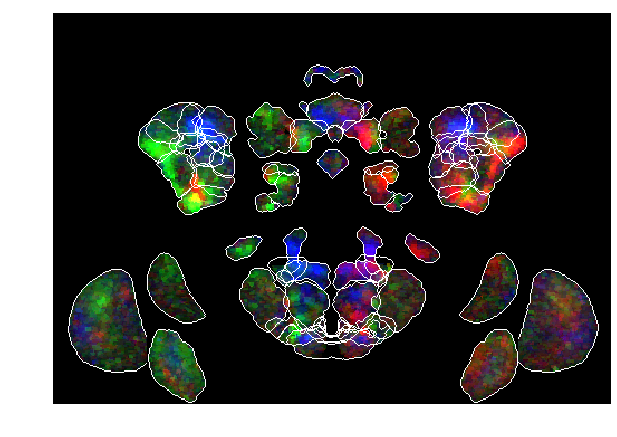

In [17]:
input_canvas = np.zeros((500,500,3))
#input_canvas = np.zeros((500,500)) #pca


x_shift=0; y_shift=0
data_map, contours = plot_grouped_roi_image(FB_group.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

x_shift=0; y_shift=-45
data_map, contours = plot_grouped_roi_image(PB.keys(), plot=False)
canvas = place_on_canvas_wrapper(canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

x_shift=0; y_shift=35
data_map, contours = plot_grouped_roi_image({23: 'EB'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

##########
### MB ###
##########

# x_shift=60; y_shift=-50
# data_map, contours = plot_grouped_roi_image(MB_left_group.keys(), plot=False)
# canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
# x_shift=-60; y_shift=-50
# data_map, contours = plot_grouped_roi_image(MB_right_group.keys(), plot=False)
# canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

#################
### BIG GROUP ###
#################

x_shift=-130; y_shift=30
data_map, contours = plot_grouped_roi_image(big_r_group.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
x_shift=130; y_shift=30
data_map, contours = plot_grouped_roi_image(big_l_group.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

##############
### VISUAL ###
##############

x_shift=-200; y_shift=175
data_map, contours = plot_grouped_roi_image({25: 'MED_R'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
x_shift=200; y_shift=175
data_map, contours = plot_grouped_roi_image({71: 'MED_L'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

x_shift=-140; y_shift=40+175
data_map, contours = plot_grouped_roi_image({3: 'LO_R'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
x_shift=140; y_shift=40+175
data_map, contours = plot_grouped_roi_image({53: 'LO_L'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

x_shift=-140; y_shift=-30+175
data_map, contours = plot_grouped_roi_image({22: 'LP_R'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
x_shift=140; y_shift=-30+175
data_map, contours = plot_grouped_roi_image({69: 'LP_L'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

canvas = wraper_wraper(canvas, ventromedial_r_group.keys(), y_shift=55, x_shift=-50)
canvas = wraper_wraper(canvas, ventromedial_l_group.keys(), y_shift=55, x_shift=50)

canvas = wraper_wraper(canvas, anterior_group.keys(), y_shift=150, x_shift=0)

canvas = wraper_wraper(canvas, {34: 'AOTU_R'}.keys(), y_shift=-50+175-15, x_shift=-80)
canvas = wraper_wraper(canvas, {79: 'AOTU_L'}.keys(), y_shift=-50+175-15, x_shift=80)
    
canvas[np.where(canvas==0)] = np.nan

plt.figure(figsize=(10,10))
plt.imshow(canvas[150:,:])
plt.axis('off')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}_zneg_unique')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

# Isolate and check relation to velocity

In [17]:
all_colored_by_betas_full.shape

(256, 128, 49, 3)

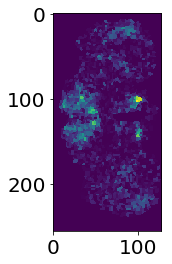

In [18]:
plt.imshow(all_colored_by_betas_full[:,:,30,2])

In [2]:
### Load Neural Data ###
all_neural = np.load('/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210514_for_aws/X_all_neural_z_vox_t_correct.npy')
all_neural.shape

(49, 2000, 30456)

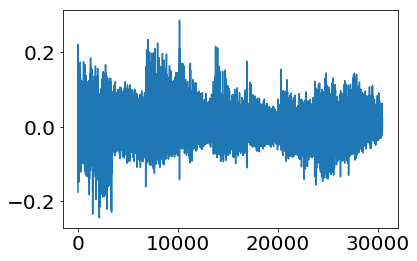

In [164]:
plt.plot(fwd_resp)

In [3]:
class Fly:
    def __init__ (self, fly_name, fly_idx):
        self.dir = os.path.join(dataset_path, fly_name, 'func_0')
        self.fly_idx = fly_idx
        self.fly_name = fly_name
        self.maps = {}
    def load_timestamps (self):
        self.timestamps = bbb.load_timestamps(os.path.join(self.dir, 'imaging'))
    def load_fictrac (self):
        self.fictrac = Fictrac(self.dir, self.timestamps)
    def load_brain_slice (self):
        self.brain = brain[:,:,:,self.fly_idx]
    def load_anatomy (self):
        to_load = os.path.join(dataset_path, self.fly_name, 'warp', 'anat-to-meanbrain.nii')
        self.anatomy = np.array(nib.load(to_load).get_data(), copy=True)
    def get_cluster_averages (self, cluster_model_labels, n_clusters):
        neural_data = self.brain.reshape(-1, 3384)
        signals = []
        self.cluster_indicies = []
        for cluster_num in range(n_clusters):
            cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
            mean_signal = np.mean(neural_data[cluster_indicies,:], axis=0)
            signals.append(mean_signal)
            self.cluster_indicies.append(cluster_indicies) # store for later
        self.cluster_signals=np.asarray(signals)
    def get_cluster_id (self, x, y):
        ax_vec = x*128 + y
        for i in range(n_clusters):
            if ax_vec in self.cluster_indicies[i]:
                cluster_id = i
                break
        return cluster_id

class Fictrac:
    def __init__ (self, fly_dir, timestamps):
        self.fictrac_raw = bbb.load_fictrac(os.path.join(fly_dir, 'fictrac'))
        self.timestamps = timestamps
    def make_interp_object(self, behavior):
        # Create camera timepoints
        fps=50
        camera_rate = 1/fps * 1000 # camera frame rate in ms
        expt_len = 1000*30*60
        x_original = np.arange(0,expt_len,camera_rate)

        # Smooth raw fictrac data
        fictrac_smoothed = scipy.signal.savgol_filter(np.asarray(self.fictrac_raw[behavior]),25,3)

        # Create interp object with camera timepoints
        fictrac_interp_object = interp1d(x_original, fictrac_smoothed, bounds_error = False)
        return fictrac_interp_object

    def pull_from_interp_object(self, interp_object, timepoints):
        new_interp = interp_object(timepoints)
        np.nan_to_num(new_interp, copy=False);
        return new_interp

    def interp_fictrac(self, z):
        behaviors = ['dRotLabY', 'dRotLabZ']; shorts = ['Y', 'Z']
        self.fictrac = {}

        for behavior, short in zip(behaviors, shorts):
            interp_object = self.make_interp_object(behavior)
            self.fictrac[short + 'i'] = interp_object

            ### Velocity ###
            low_res_behavior = self.pull_from_interp_object(interp_object, self.timestamps[:,z])
            self.fictrac[short] = low_res_behavior#/np.std(low_res_behavior)

            ### Clipped Velocities ###
            self.fictrac[short + '_pos'] = np.clip(self.fictrac[short], a_min=0, a_max=None)
            self.fictrac[short + '_neg'] = np.clip(self.fictrac[short], a_min=None, a_max=0)*-1

            ### Strongly Clipped Velocities ###
            # excludes points even close to 0
            #self.fictrac[short + '_pos_very'] = np.clip(self.fictrac[short], a_min=0.3, a_max=None)
            #self.fictrac[short + '_neg_very'] = np.clip(self.fictrac[short], a_min=None, a_max=-0.3)*-1

            ### Acceleration ###
            high_res_behavior = self.pull_from_interp_object(interp_object, high_res_timepoints)
            self.fictrac[short + 'h'] = high_res_behavior/np.std(high_res_behavior)

            accel = scipy.signal.savgol_filter(np.diff(high_res_behavior),25,3)
            accel = np.append(accel, 0)
            interp_object = interp1d(high_res_timepoints, accel, bounds_error = False)
            acl = interp_object(self.timestamps[:,z])
            acl[-1] = 0
            self.fictrac[short + 'a'] = acl#/np.std(acl)

            ### Clipped Acceleration ###
            self.fictrac[short + 'a' + '_pos'] = np.clip(self.fictrac[short + 'a'], a_min=0, a_max=None)
            self.fictrac[short + 'a' + '_neg'] = np.clip(self.fictrac[short + 'a'], a_min=None, a_max=0)*-1

        self.fictrac['YZ'] = np.sqrt(np.power(self.fictrac['Y'],2), np.power(self.fictrac['Z'],2))
        self.fictrac['YZh'] = np.sqrt(np.power(self.fictrac['Yh'],2), np.power(self.fictrac['Zh'],2))

fly_names = ['fly_087', 'fly_089', 'fly_094', 'fly_097', 'fly_098', 'fly_099', 'fly_100', 'fly_101', 'fly_105']
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset"
expt_len = 1000*30*60
resolution = 10
high_res_timepoints = np.arange(0,expt_len,resolution) #0 to last time at subsample res

###################
### Build Flies ###
###################
z=25
flies = {}
for i, fly in enumerate(fly_names):
    flies[fly] = Fly(fly_name=fly, fly_idx=i)
    flies[fly].load_timestamps()
    flies[fly].load_fictrac()
    flies[fly].fictrac.interp_fictrac(z)


~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 73.57 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 5.49 sec

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 53.57 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 5.59 sec

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 110.59 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 5.54 sec

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 49.10 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 5.51 sec

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 63.53 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 5.67 sec

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 43.0

In [4]:
expt_len = 1000*30*60
resolution = 10
high_res_timepoints = np.arange(0,expt_len,resolution) #0 to last time at subsample res

class Fictrac:
    def __init__ (self, fly_dir, timestamps):
        self.fictrac_raw = bbb.load_fictrac(os.path.join(fly_dir, 'fictrac'))
        self.timestamps = timestamps
    def make_interp_object(self, behavior):
        # Create camera timepoints
        fps=50
        camera_rate = 1/fps * 1000 # camera frame rate in ms
        expt_len = 1000*30*60
        x_original = np.arange(0,expt_len,camera_rate)

        # Smooth raw fictrac data
        fictrac_smoothed = scipy.signal.savgol_filter(np.asarray(self.fictrac_raw[behavior]),25,3)

        # Create interp object with camera timepoints
        fictrac_interp_object = interp1d(x_original, fictrac_smoothed, bounds_error = False)
        return fictrac_interp_object

    def pull_from_interp_object(self, interp_object, timepoints):
        new_interp = interp_object(timepoints)
        np.nan_to_num(new_interp, copy=False);
        return new_interp

    def interp_fictrac(self):
        behaviors = ['dRotLabY', 'dRotLabZ']; shorts = ['Y', 'Z']
        self.fictrac = {}

        ### Y and Z ###
        for behavior, short in zip(behaviors, shorts):
            interp_object = self.make_interp_object(behavior)
            self.fictrac[short + 'i'] = interp_object

            ### Interpolate to neural data
            self.fictrac[short] = []
            self.fictrac[short + '_pos'] = []
            self.fictrac[short + '_neg'] = []
            for z in range(49):
                ### Velocity ###
                low_res_behavior = self.pull_from_interp_object(interp_object, self.timestamps[:,z])
                #self.fictrac[short].append(low_res_behavior/np.std(low_res_behavior))
                self.fictrac[short].append(low_res_behavior)

                ### Clipped Velocities ###
                self.fictrac[short + '_pos'].append(np.clip(self.fictrac[short][-1], a_min=0, a_max=None))
                self.fictrac[short + '_neg'].append(np.clip(self.fictrac[short][-1], a_min=None, a_max=0)*-1)
                
            ### 10Hz interp ###
            expt_len = 1000*30*60
            sample_in_ms = 100
            x_hz10 = np.arange(0,expt_len,sample_in_ms)
            hz10_res_behavior = self.pull_from_interp_object(interp_object, x_hz10)
            self.fictrac[short + '_10hz'] = hz10_res_behavior
            self.fictrac[short + '_pos_10hz'] = np.clip(hz10_res_behavior, a_min=0, a_max=None)
            self.fictrac[short + '_neg_10hz'] = np.clip(hz10_res_behavior, a_min=None, a_max=0) * -1

        ### Walking ###
        self.fictrac['walking'] = []
        for z in range(49):    
            YZ = np.sqrt(np.power(self.fictrac['Y'][z],2), np.power(self.fictrac['Z'][z],2))        
            self.fictrac['walking'].append(np.zeros(3384))
            self.fictrac['walking'][-1][np.where(YZ>.2)] = 1

class Fly:
    def __init__ (self, fly_name, fly_idx):
        self.dir = os.path.join(dataset_path, fly_name, 'func_0')
        self.fly_idx = fly_idx
        self.fly_name = fly_name
        self.maps = {}
    def load_timestamps (self):
        self.timestamps = bbb.load_timestamps(os.path.join(self.dir, 'imaging'))
    def load_fictrac (self):
        self.fictrac = Fictrac(self.dir, self.timestamps)
    def load_brain_slice (self):
        self.brain = brain[:,:,:,self.fly_idx]
    def load_anatomy (self):
        to_load = os.path.join(dataset_path, self.fly_name, 'warp', 'anat-to-meanbrain.nii')
        self.anatomy = np.array(nib.load(to_load).get_data(), copy=True)
    def load_z_depth_correction (self):
        to_load = os.path.join(dataset_path, self.fly_name, 'warp', '20201220_warped_z_depth.nii')
        self.z_correction = np.array(nib.load(to_load).get_data(), copy=True)
    def get_cluster_averages (self, cluster_model_labels, n_clusters):
        neural_data = self.brain.reshape(-1, 3384)
        signals = []
        self.cluster_indicies = []
        for cluster_num in range(n_clusters):
            cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
            mean_signal = np.mean(neural_data[cluster_indicies,:], axis=0)
            signals.append(mean_signal)
            self.cluster_indicies.append(cluster_indicies) # store for later
        self.cluster_signals=np.asarray(signals)
    def get_cluster_id (self, x, y):
        ax_vec = x*128 + y
        for i in range(n_clusters):
            if ax_vec in self.cluster_indicies[i]:
                cluster_id = i
                break
        return cluster_id
    
flies = {}
for i, fly in enumerate(fly_names):
    print(F'*** fly: {fly} ***')
    flies[fly] = Fly(fly_name=fly, fly_idx=i)
    flies[fly].load_timestamps()
    flies[fly].load_fictrac()
    flies[fly].fictrac.interp_fictrac()

*** fly: fly_087 ***

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 4.33 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 2.98 sec
*** fly: fly_089 ***

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 4.24 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 2.98 sec
*** fly: fly_094 ***

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 3.95 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.03 sec
*** fly: fly_097 ***

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 3.72 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 2.89 sec
*** fly: fly_098 ***

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 3.75 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 2.92 sec
*** fly: fly_09

In [5]:
#####################
### Pool behavior ###
#####################
not_clipped_behaviors = ['Y', 'Z', 'Ya', 'Za']
clipped_behaviors = ['Y_pos', 'Y_neg',
                     'Z_pos', 'Z_neg',
                     'Ya_pos', 'Ya_neg',
                     'Za_pos', 'Za_neg']
all_behaviors = not_clipped_behaviors + clipped_behaviors

pooled_behavior = {}
for j, behavior in enumerate(all_behaviors):
    pooled_behavior[behavior] = []
    for i,fly in enumerate(flies):
        pooled_behavior[behavior].append(flies[fly].fictrac.fictrac[behavior])
    pooled_behavior[behavior] = np.asarray(pooled_behavior[behavior]).flatten()

KeyError: 'Ya'

In [9]:
z = 20
sphere_radius = 4.5e-3 # in m
fps=50
behaviors = ['Y', 'Z', 'Y_pos', 'Z_pos', 'Z_neg']
behavior_super = {}
for behavior in behaviors:
    behavior_super[behavior] = []
    for fly in fly_names:
        behavior_super[behavior].extend((flies[fly].fictrac.fictrac[behavior][z]))
    behavior_super[behavior] = np.asarray(behavior_super[behavior])
    behavior_super[behavior + '_std'] = behavior_super[behavior]/np.std(behavior_super[behavior])
    
    if behavior in ['Y', 'Y_pos']:
        ''' starts with units of rad/frame
        * sphere_radius(m); now in m/frame
        * fps; now in m/sec
        * 1000; now in mm/sec '''
        behavior_super[behavior + '_units'] = behavior_super[behavior] * sphere_radius * fps * 1000 # mm/sec
        
    elif behavior in ['Z', 'Z_pos', 'Z_neg']:
        ''' starts with units of rad/frame
        * 180 / np.pi; now in deg/frame
        * fps; now in deg/sec '''
        behavior_super[behavior + '_units'] = behavior_super[behavior] * 180 / np.pi * fps ## deg/sec

In [ ]:
empty = np.zeros(all_colored_by_betas_full.shape)
empty[np.where(all_colored_by_betas_full[...,2]>.015)] = 1

plt.figure(figsize=(10,10))
for i in range(9,40):
    plt.subplot(6,6,i-8)
    plt.imshow(empty[:,:,i,2].T)
    plt.axis('off')
plt.subplots_adjust(wspace=0,hspace=-.8)

In [19]:
# #### unweighted version ###
# scores1 = 'scores_all'
# unique = 'scores_ypos_unique'
# thresh = 0.015
# reponding_voxels = np.zeros((0,30456))

# for z in range(9,49-9):
#     a = all_scores[z-9][scores1]
#     b = all_scores[z-9][unique]
#     c = [a[i]-b[i] for i in range(2000)] # get unique glm score for each of 2000 supervoxels
#     d = np.where(np.asarray(c)>thresh)[0] # which voxels have a high score
#     e = all_neural[z,d,:] # get actual voxel values
#     reponding_voxels = np.concatenate((reponding_voxels, e))
# reponding_voxels.shape
# fwd_resp = np.mean(reponding_voxels,axis=0)

In [10]:
#### Weighted Version ###
scores1 = 'scores_all'
unique = 'scores_ypos_unique'
thresh = 0.015
reponding_voxels = np.zeros((0,30456))
weights = []

for z in range(9,49-9):
    a = all_scores[z-9][scores1]
    b = all_scores[z-9][unique]
    c = [a[i]-b[i] for i in range(2000)] # get unique glm score for each of 2000 supervoxels
    d = np.where(np.asarray(c)>thresh)[0] # which voxels have a high score
    e = all_neural[z,d,:] # get actual voxel values
    weights.extend(np.asarray(c)[d])
    reponding_voxels = np.concatenate((reponding_voxels, e))
fwd_resp = np.average(reponding_voxels,weights=weights,axis=0)

NameError: name 'all_scores' is not defined

Text(0.5, 0, 'Y_Pos velocity')

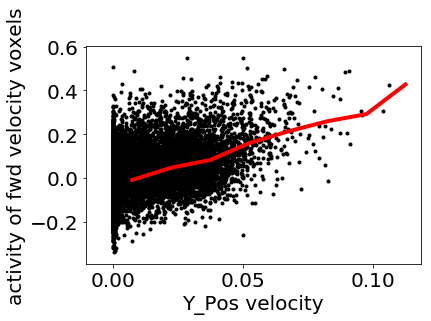

In [33]:
# unique forward...

# make x bins, get mean y in each bin
beh = pooled_behavior['Y_pos']
neu = fwd_resp#resp['scores_ypos_unique']
num_bins = 10
xbins = np.linspace(0,.15,num_bins+1)
avgs = []
for i in range(num_bins):
    start = xbins[i]
    end = xbins[i+1]
    a = np.where(np.logical_and(beh>start, beh<=end))
    avgs.append(np.mean(neu[a]))

step = xbins[1] - xbins[0]
mids = [i+step/2 for i in xbins]
plt.scatter(beh,neu,marker='.',color='k')
plt.plot(mids[:-1],avgs,color='r',lw=4)
plt.ylabel('activity of fwd velocity voxels')
plt.xlabel('Y_Pos velocity')

Text(0.5, 0, 'Y_Pos velocity')

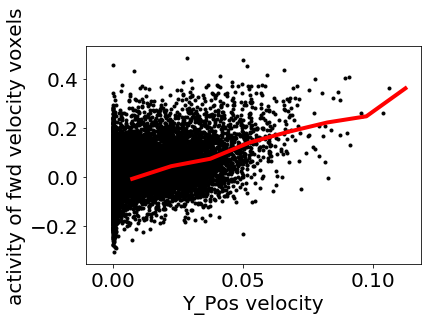

In [23]:
# make x bins, get mean y in each bin
beh = pooled_behavior['Y_pos']
neu = fwd_resp#resp['scores_ypos_unique']
num_bins = 10
xbins = np.linspace(0,.15,num_bins+1)
avgs = []
for i in range(num_bins):
    start = xbins[i]
    end = xbins[i+1]
    a = np.where(np.logical_and(beh>start, beh<=end))
    avgs.append(np.mean(neu[a]))

step = xbins[1] - xbins[0]
mids = [i+step/2 for i in xbins]
plt.scatter(beh,neu,marker='.',color='k')
plt.plot(mids[:-1],avgs,color='r',lw=4)
plt.ylabel('activity of fwd velocity voxels')
plt.xlabel('Y_Pos velocity')

In [12]:
uniques = ['scores_ypos_unique', 'scores_zpos_unique', 'scores_zneg_unique']
scores1 = 'scores_all'
thresh = .03 #0.015
resp = {}

for unique in uniques:
    print(unique)
    weights = []
    reponding_voxels = np.zeros((0,30456))
    for z in range(9,49-9):
        a = all_scores[z-9][scores1]
        b = all_scores[z-9][unique]
        c = [a[i]-b[i] for i in range(2000)] # get unique glm score for each of 2000 supervoxels
        d = np.where(np.asarray(c)>thresh)[0] # which voxels have a high score
        e = all_neural[z,d,:] # get actual voxel values
        weights.extend(np.asarray(c)[d])
        reponding_voxels = np.concatenate((reponding_voxels, e))
    print(reponding_voxels.shape)
    resp[unique] = np.mean(reponding_voxels,axis=0)
    #resp[unique] = np.average(reponding_voxels,weights=weights,axis=0)
    
    

scores_ypos_unique
(513, 30456)
scores_zpos_unique
(336, 30456)
scores_zneg_unique
(560, 30456)


In [22]:
### SINGLES ###

uniques = ['scores_ypos', 'scores_zpos', 'scores_zneg']
thresh = 0.015
resp = {}

for unique in uniques:
    print(unique)
    weights = []
    reponding_voxels = np.zeros((0,30456))
    for z in range(9,49-9):
        #a = all_scores[z-9][scores1]
        b = all_scores[z-9][unique]
        #c = [a[i]-b[i] for i in range(2000)] # get unique glm score for each of 2000 supervoxels
        d = np.where(np.asarray(b)>thresh)[0] # which voxels have a high score
        e = all_neural[z,d,:] # get actual voxel values
        weights.extend(np.asarray(b)[d])
        reponding_voxels = np.concatenate((reponding_voxels, e))
    print(reponding_voxels.shape)
    resp[unique] = np.mean(reponding_voxels,axis=0)
    #resp[unique] = np.average(reponding_voxels,weights=weights,axis=0)
    
    

scores_ypos
(18061, 30456)
scores_zpos


KeyboardInterrupt: 

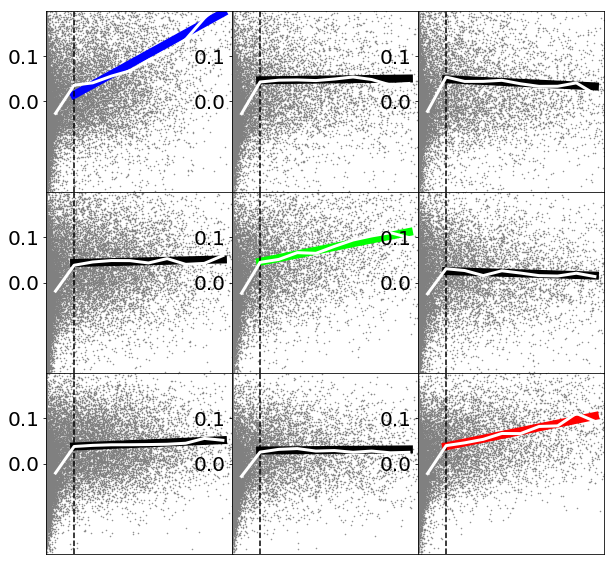

In [13]:
plt.figure(figsize=(10,10))
cnt = 0
rs_low = []
ps_low = []
rs_high = []
ps_high = []

for neu in ['scores_ypos_unique', 'scores_zpos_unique', 'scores_zneg_unique']:
    for beh in ['Y_pos_std', 'Z_pos_std', 'Z_neg_std']:
        cnt+=1
        plt.subplot(3,3,cnt)
        
        # make x bins, get mean y in each bin
        num_bins = 10
        xbins = np.linspace(0,5,num_bins+1)
        step = xbins[1] - xbins[0]
        mids = [i+step/2 for i in xbins]
        avgs = []
        stds = []
        cnts = []
        for i in range(num_bins):
            start = xbins[i]
            end = xbins[i+1]
            a = np.where(np.logical_and(behavior_super[beh]>start, behavior_super[beh]<=end))
            avgs.append(np.mean(resp[neu][a]))
            stds.append(np.std(resp[neu][a]))
            cnts.append(len(a[0]))
            #plt.boxplot(list(resp[neu][a]),positions=[mids[i]], showfliers=False)

        plt.scatter(behavior_super[beh],resp[neu],marker='.',color='grey',s=1)
        #plt.plot(mids[:-1],avgs,color='r',lw=1,marker='o')
        
        ### Plot line along bins, with error bar ###
        sem = [stds[i]/np.sqrt(cnts[i]) for i in range(len(mids)-1)]
        plt.errorbar(mids[:-1], avgs, yerr=sem, label='both limits (default)',color='w',lw=3)
        
        ### Fit line to data above the threshold ###
        start = mids[1]
        end = 10
        a = np.where(np.logical_and(behavior_super[beh]>start, behavior_super[beh]<=end))
        m, b = np.polyfit(behavior_super[beh][a], resp[neu][a], 1)
        x=[.75,mids[-2]]
        colors = ['blue','k','k','k',(0,1,0),'k','k','k','r']
        plt.plot(x, [i*m + b for i in x],color=colors[cnt-1],lw=8)
        r, p = scipy.stats.pearsonr(behavior_super[beh][a], resp[neu][a])
        rs_high.append(r)
        ps_high.append(p)
        
        ### Fit line to data BELOW the threshold ###
        start = 0
        end = .75
        a = np.where(np.logical_and(behavior_super[beh]>start, behavior_super[beh]<=end))
        #m, b = np.polyfit(behavior_super[beh][a], resp[neu][a], 1)
#         x=[0,xbins[1]]
#         plt.plot(x, [i*m + b for i in x],color='r',lw=8)
        r, p = scipy.stats.pearsonr(behavior_super[beh][a], resp[neu][a])
        rs_low.append(r)
        ps_low.append(p)
        
        
        plt.axvline(mids[1],color='k',linestyle='--')
        plt.xlim(0,5)
        plt.ylim(-.2,.2)
        plt.xticks([])
        plt.yticks([0,.1])
        #plt.title(F'{r:.2f},{p:.2f}',fontsize=12)
        
plt.subplots_adjust(wspace=0,hspace=0)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

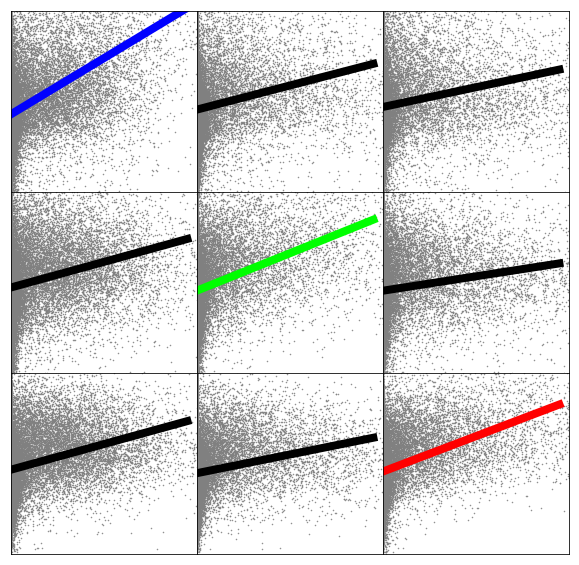

In [19]:
### version without below and above (just one line)

plt.figure(figsize=(10,10))
cnt = 0
rs_all = []
ps_all = []

for neu in ['scores_ypos_unique', 'scores_zpos_unique', 'scores_zneg_unique']:
    for beh in ['Y_pos_std', 'Z_pos_std', 'Z_neg_std']:
        cnt+=1
        plt.subplot(3,3,cnt)
        
        # make x bins, get mean y in each bin
        num_bins = 10
        xbins = np.linspace(0,5,num_bins+1)
        step = xbins[1] - xbins[0]
        mids = [i+step/2 for i in xbins]
        avgs = []
        stds = []
        cnts = []
        for i in range(num_bins):
            start = xbins[i]
            end = xbins[i+1]
            a = np.where(np.logical_and(behavior_super[beh]>start, behavior_super[beh]<=end))
            avgs.append(np.mean(resp[neu][a]))
            stds.append(np.std(resp[neu][a]))
            cnts.append(len(a[0]))
            #plt.boxplot(list(resp[neu][a]),positions=[mids[i]], showfliers=False)

        plt.scatter(behavior_super[beh],resp[neu],marker='.',color='grey',s=1)
        #plt.plot(mids[:-1],avgs,color='r',lw=1,marker='o')
        
        ### Plot line along bins, with error bar ###
        sem = [stds[i]/np.sqrt(cnts[i]) for i in range(len(mids)-1)]
        #plt.errorbar(mids[:-1], avgs, yerr=sem, label='both limits (default)',color='w',lw=3)
        
#         ### Fit line to data above the threshold ###
#         start = mids[1]
#         end = 10
#         a = np.where(np.logical_and(behavior_super[beh]>start, behavior_super[beh]<=end))
#         m, b = np.polyfit(behavior_super[beh][a], resp[neu][a], 1)
#         x=[.75,mids[-2]]
#         colors = ['blue','k','k','k',(0,1,0),'k','k','k','r']
#         plt.plot(x, [i*m + b for i in x],color=colors[cnt-1],lw=8)
#         r, p = scipy.stats.pearsonr(behavior_super[beh][a], resp[neu][a])
#         rs_high.append(r)
#         ps_high.append(p)
        
#         ### Fit line to data BELOW the threshold ###
#         start = 0
#         end = .75
#         a = np.where(np.logical_and(behavior_super[beh]>start, behavior_super[beh]<=end))
#         #m, b = np.polyfit(behavior_super[beh][a], resp[neu][a], 1)
# #         x=[0,xbins[1]]
# #         plt.plot(x, [i*m + b for i in x],color='r',lw=8)
#         r, p = scipy.stats.pearsonr(behavior_super[beh][a], resp[neu][a])
#         rs_low.append(r)
#         ps_low.append(p)
        
        start = 0
        end = 10
        a = np.where(np.logical_and(behavior_super[beh]>start, behavior_super[beh]<=end))
        m, b = np.polyfit(behavior_super[beh][a], resp[neu][a], 1)
        x=[0,mids[-2]]
        colors = ['blue','k','k','k',(0,1,0),'k','k','k','r']
        plt.plot(x, [i*m + b for i in x],color=colors[cnt-1],lw=8)
        r, p = scipy.stats.pearsonr(behavior_super[beh][a], resp[neu][a])
        rs_all.append(r)
        ps_all.append(p)
        
        #plt.axvline(mids[1],color='k',linestyle='--')
        plt.xlim(0,5)
        plt.ylim(-.2,.2)
        plt.xticks([])
        plt.yticks([])
        #plt.title(F'{r:.2f},{p:.2f}',fontsize=12)
        
plt.subplots_adjust(wspace=0,hspace=0)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

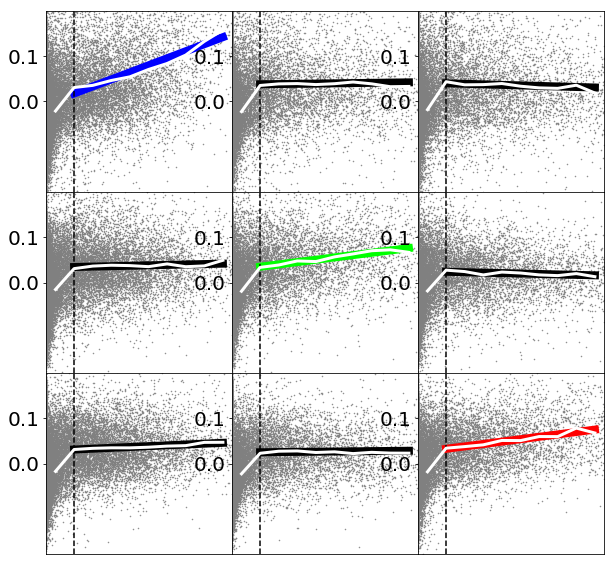

In [170]:
plt.figure(figsize=(10,10))
cnt = 0
rs_low = []
ps_low = []
rs_high = []
ps_high = []

for neu in ['scores_ypos_unique', 'scores_zpos_unique', 'scores_zneg_unique']:
    for beh in ['Y_pos_std', 'Z_pos_std', 'Z_neg_std']:
        cnt+=1
        plt.subplot(3,3,cnt)
        
        # make x bins, get mean y in each bin
        num_bins = 10
        xbins = np.linspace(0,5,num_bins+1)
        step = xbins[1] - xbins[0]
        mids = [i+step/2 for i in xbins]
        avgs = []
        stds = []
        cnts = []
        for i in range(num_bins):
            start = xbins[i]
            end = xbins[i+1]
            a = np.where(np.logical_and(behavior_super[beh]>start, behavior_super[beh]<=end))
            avgs.append(np.mean(resp[neu][a]))
            stds.append(np.std(resp[neu][a]))
            cnts.append(len(a[0]))
            #plt.boxplot(list(resp[neu][a]),positions=[mids[i]], showfliers=False)

        plt.scatter(behavior_super[beh],resp[neu],marker='.',color='grey',s=1)
        #plt.plot(mids[:-1],avgs,color='r',lw=1,marker='o')
        
        ### Plot line along bins, with error bar ###
        sem = [stds[i]/np.sqrt(cnts[i]) for i in range(len(mids)-1)]
        plt.errorbar(mids[:-1], avgs, yerr=sem, label='both limits (default)',color='w',lw=3)
        
        ### Fit line to data above the threshold ###
        start = mids[1]
        end = 10
        a = np.where(np.logical_and(behavior_super[beh]>start, behavior_super[beh]<=end))
        m, b = np.polyfit(behavior_super[beh][a], resp[neu][a], 1)
        x=[.75,mids[-2]]
        colors = ['blue','k','k','k',(0,1,0),'k','k','k','r']
        plt.plot(x, [i*m + b for i in x],color=colors[cnt-1],lw=8)
        r, p = scipy.stats.pearsonr(behavior_super[beh][a], resp[neu][a])
        rs_high.append(r)
        ps_high.append(p)
        
        ### Fit line to data BELOW the threshold ###
        start = 0
        end = .75
        a = np.where(np.logical_and(behavior_super[beh]>start, behavior_super[beh]<=end))
        #m, b = np.polyfit(behavior_super[beh][a], resp[neu][a], 1)
#         x=[0,xbins[1]]
#         plt.plot(x, [i*m + b for i in x],color='r',lw=8)
        r, p = scipy.stats.pearsonr(behavior_super[beh][a], resp[neu][a])
        rs_low.append(r)
        ps_low.append(p)
        
        
        plt.axvline(mids[1],color='k',linestyle='--')
        plt.xlim(0,5)
        plt.ylim(-.2,.2)
        plt.xticks([])
        plt.yticks([0,.1])
        #plt.title(F'{r:.2f},{p:.2f}',fontsize=12)
        
plt.subplots_adjust(wspace=0,hspace=0)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

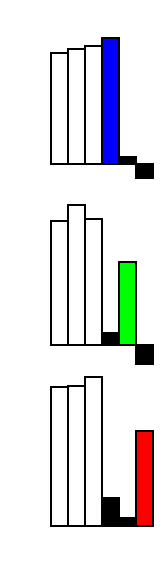

In [218]:
plt.figure(figsize=(2,10))
plt.subplot(3,1,1)
plt.bar([1,2,3,4,5,6],rs_low[:3]+rs_high[:3],
        color=['w','w','w','b','k','k'],width=1.0,edgecolor='k',lw=2)
plt.ylim(-0.07,.45)
# plt.xticks([])
# plt.yticks([])
plt.axis('off')

plt.subplot(3,1,2)
plt.bar([1,2,3,4,5,6],rs_low[3:6]+rs_high[3:6],
        color=['w','w','w','k',(0,1,0),'k'],width=1.0,edgecolor='k',lw=2)
plt.ylim(-0.07,.45)
# plt.xticks([])
# plt.yticks([])
plt.axis('off')

plt.subplot(3,1,3)
plt.bar([1,2,3,4,5,6],rs_low[6:9]+rs_high[6:9],
        color=['w','w','w','k','k','r'],width=1.0,edgecolor='k',lw=2)
plt.ylim(-0.07,.45)
# plt.xticks([])
# plt.yticks([])
plt.axis('off')

plt.subplots_adjust(wspace=0,hspace=0)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight')

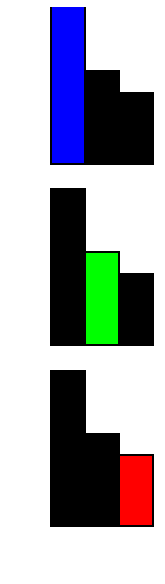

In [24]:
### single line version (rs_all)

plt.figure(figsize=(2,10))
plt.subplot(3,1,1)
plt.bar([1,2,3],rs_all[:3],
        color=['b','k','k'],width=1.0,edgecolor='k',lw=2)
plt.ylim(-0.07,.45)
# plt.xticks([])
# plt.yticks([])
plt.axis('off')

plt.subplot(3,1,2)
plt.bar([1,2,3],rs_all[:3],
        color=['k',(0,1,0),'k'],width=1.0,edgecolor='k',lw=2)
plt.ylim(-0.07,.45)
# plt.xticks([])
# plt.yticks([])
plt.axis('off')

plt.subplot(3,1,3)
plt.bar([1,2,3],rs_all[:3],
        color=['k','k','r'],width=1.0,edgecolor='k',lw=2)
plt.ylim(-0.07,.45)
# plt.xticks([])
# plt.yticks([])
plt.axis('off')

plt.subplots_adjust(wspace=0,hspace=0)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight')

In [215]:
ps_high

[2.1215439992266966e-214,
 0.21224379938918778,
 0.007712091935925983,
 0.0035131891316282095,
 2.31344286886509e-58,
 0.0002996036706083418,
 2.212331006250629e-11,
 0.10707580350179918,
 2.380758301051894e-80]

In [175]:
rs_low

[0.31968085958083003,
 0.32867074430367416,
 0.33759132061579533,
 0.3553417845870465,
 0.4033068432560064,
 0.36206755696230947,
 0.39988136219007603,
 0.40159202756083906,
 0.4280527743405708,
 0.31968085958083003,
 0.32867074430367416,
 0.33759132061579533,
 0.3553417845870465,
 0.4033068432560064,
 0.36206755696230947,
 0.39988136219007603,
 0.40159202756083906,
 0.4280527743405708]

In [161]:
ratio = np.max(behavior_super['Z_std'])/np.max(behavior_super['Z_units'])
ratio*400

5.0655686248345235

In [167]:
ratio = np.max(behavior_super['Y_std'])/np.max(behavior_super['Y_units'])
4/ratio

9.710273934872976

59.2233611305187

In [156]:
ratio = np.max(behavior_super['Z_std'])/np.max(behavior_super['Z_units'])
ax_main.set_yticklabels([-300, 0, 300])
ax_main.set_yticks([-300*ratio, 0, 300*ratio])

ratio = np.max(behavior_super['Y_std'])/np.max(behavior_super['Y_units'])
ax_main.set_xticklabels([0, 10])
ax_main.set_xticks([0, 10*ratio])

0.75

In [157]:
mids[-2]

4.75

In [108]:
sem

NameError: name 'sem' is not defined

In [99]:
mids[0]

0.25

{'boxes': [<matplotlib.lines.Line2D at 0x7f456de3b588>,
 'caps': [<matplotlib.lines.Line2D at 0x7f456dec1cf8>,
 'fliers': [],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f456de2a128>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f456de3b8d0>,
  <matplotlib.lines.Line2D at 0x7f456de19c18>]}

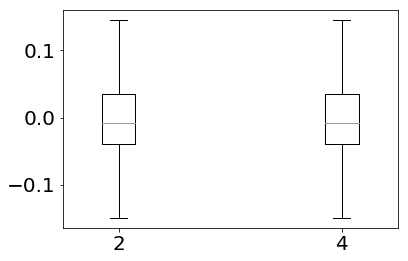

In [95]:
plt.boxplot([resp[neu],resp[neu]],positions=[2,4], showfliers=False)

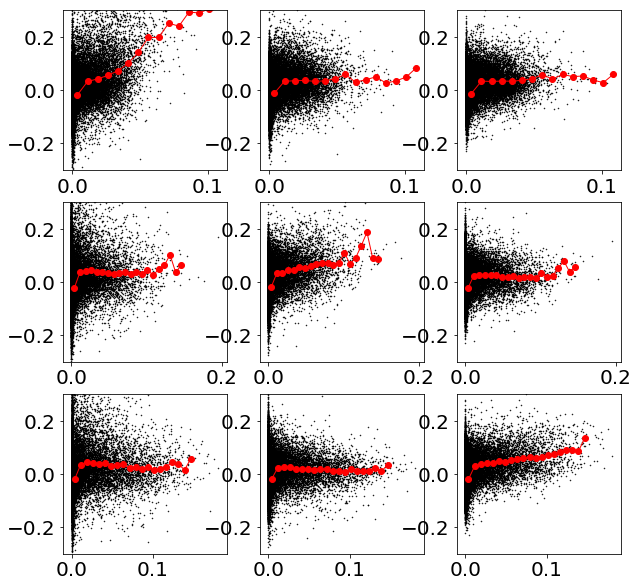

In [71]:
plt.figure(figsize=(10,10))
cnt = 0
for beh in ['Y_pos', 'Z_pos', 'Z_neg']:
    for neu in ['scores_ypos_unique', 'scores_zpos_unique', 'scores_zneg_unique']:
        cnt+=1
        plt.subplot(3,3,cnt)
        
        # make x bins, get mean y in each bin
        num_bins = 20
        xbins = np.linspace(0,.15,num_bins+1)
        avgs = []
        stds = []
        cnts = []
        for i in range(num_bins):
            start = xbins[i]
            end = xbins[i+1]
            a = np.where(np.logical_and(pooled_behavior[beh]>start, pooled_behavior[beh]<=end))
            avgs.append(np.mean(resp[neu][a]))
            stds.append(np.std(resp[neu][a]))
            cnts.append(len(a[0]))

        step = xbins[1] - xbins[0]
        mids = [i+step/2 for i in xbins]
        plt.scatter(pooled_behavior[beh],resp[neu],marker='.',color='k',s=1)
        
        plt.plot(mids[:-1],avgs,color='r',lw=1,marker='o')
        #plt.axvline(.)
#         plt.ylabel(neu)
#         plt.xlabel(beh)
        #plt.xlim(0,.1)
        plt.ylim(-.3,.3)
        r, p = scipy.stats.pearsonr(pooled_behavior[beh], resp[neu])
        #plt.title(F'{r:.2f}')

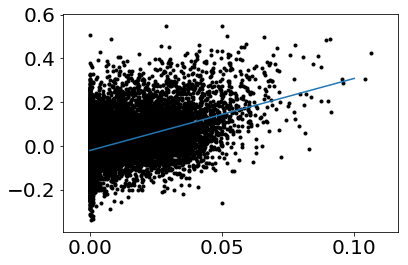

In [61]:
neu = 'scores_ypos_unique'
beh = 'Y_pos'
plt.scatter(pooled_behavior[beh],resp[neu],marker='.',color='k')

m, b = np.polyfit(pooled_behavior[beh], resp[neu], 1)
x=[0,.1]
plt.plot(x, [i*m + b for i in x])

In [ ]:
# I want to fit a line to the data after the bump
# 

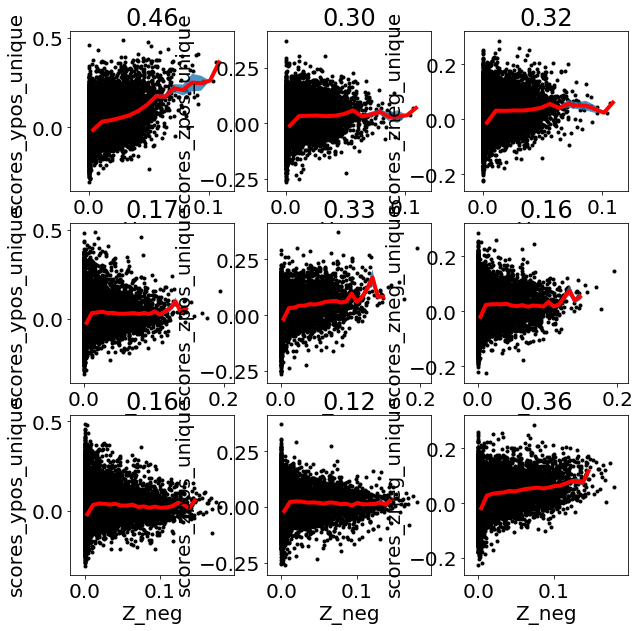

In [242]:
plt.figure(figsize=(10,10))



cnt = 0
for beh in ['Y_pos', 'Z_pos', 'Z_neg']:
    for neu in ['scores_ypos_unique', 'scores_zpos_unique', 'scores_zneg_unique']:
        cnt+=1
        plt.subplot(3,3,cnt)
        
        # make x bins, get mean y in each bin
        num_bins = 20
        xbins = np.linspace(0,.15,num_bins+1)
        avgs = []
        stds = []
        cnts = []
        for i in range(num_bins):
            start = xbins[i]
            end = xbins[i+1]
            a = np.where(np.logical_and(pooled_behavior[beh]>start, pooled_behavior[beh]<=end))
            avgs.append(np.mean(resp[neu][a]))
            stds.append(np.std(resp[neu][a]))
            cnts.append(len(a[0]))

        step = xbins[1] - xbins[0]
        mids = [i+step/2 for i in xbins]
        plt.scatter(pooled_behavior[beh],resp[neu],marker='.',color='k')
        plt.plot(mids[:-1],avgs,color='r',lw=4)
        plt.fill_between(mids[:-1], 
                         [avgs[i] - stds[i]/np.sqrt(cnts[i]) for i in range(len(mids)-1)],
                         [avgs[i] + stds[i]/np.sqrt(cnts[i]) for i in range(len(mids)-1)],
                         alpha=0.8)
        plt.ylabel(neu)
        plt.xlabel(beh)

        r, p = scipy.stats.pearsonr(pooled_behavior[beh], resp[neu])
        plt.title(F'{r:.2f}')

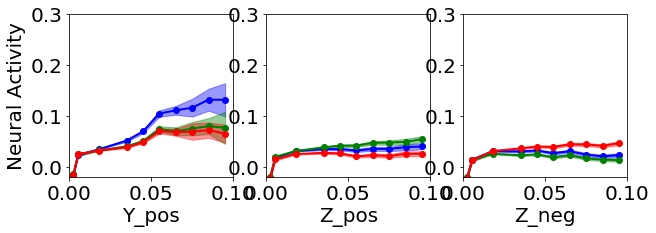

In [46]:
plt.figure(figsize=(10,3))
colors = {'scores_ypos': 'blue', 'scores_zpos': 'green', 'scores_zneg': 'red'}

cnt = 0
for j, beh in enumerate(['Y_pos', 'Z_pos', 'Z_neg']):
    for k, neu in enumerate(['scores_ypos', 'scores_zpos', 'scores_zneg']):
        cnt+=1
        plt.subplot(1,3,j+1)
        
        # make x bins, get mean y in each bin
        num_bins = 10
        xbins = np.linspace(0,.1,num_bins+1)
        xbins[1] = .005
        xbins[2] = .006
        avgs = []
        stds = []
        cnts = []
        for i in range(num_bins):
            start = xbins[i]
            end = xbins[i+1]
            a = np.where(np.logical_and(pooled_behavior[beh]>start, pooled_behavior[beh]<=end))
            avgs.append(np.mean(resp[neu][a]))
            stds.append(np.std(resp[neu][a]))
            cnts.append(len(a[0]))

        #step = xbins[1] - xbins[0]
        mids = [((xbins[i+1]-xbins[i])/2)+xbins[i] for i in range(len(xbins)-1)]
        #mids = [i+step/2 for i in xbins]
        #plt.scatter(pooled_behavior[beh],resp[neu],marker='.',color='k')
        color = colors[neu]
        plt.plot(mids,avgs,color=color,lw=2,marker='o')
        plt.fill_between(mids, 
                         [avgs[i] - stds[i]/np.sqrt(cnts[i]) for i in range(len(mids))],
                         [avgs[i] + stds[i]/np.sqrt(cnts[i]) for i in range(len(mids))],
                         alpha=0.4,
                         color=color)
        if j == 0:
            plt.ylabel('Neural Activity')
        plt.xlabel(beh)
        plt.ylim(-.02,.3)
        plt.xlim(0,.1)
        #plt.title()

        #r, p = scipy.stats.pearsonr(pooled_behavior[beh], resp[neu])
        #plt.title(F'{r:.2f}')
        
        # here, each plot shows one voxel type, and the 3 colors show its response to beh
        # now i've switched it! each plot shows 1 behavior

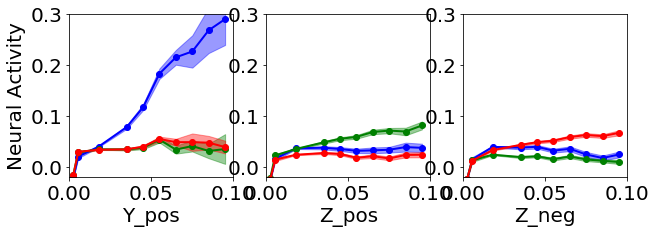

In [36]:
plt.figure(figsize=(10,3))
colors = {'scores_ypos_unique': 'blue', 'scores_zpos_unique': 'green', 'scores_zneg_unique': 'red'}

cnt = 0
for j, beh in enumerate(['Y_pos', 'Z_pos', 'Z_neg']):
    for k, neu in enumerate(['scores_ypos_unique', 'scores_zpos_unique', 'scores_zneg_unique']):
        cnt+=1
        plt.subplot(1,3,j+1)
        
        # make x bins, get mean y in each bin
        num_bins = 10
        xbins = np.linspace(0,.1,num_bins+1)
        xbins[1] = .005
        xbins[2] = .006
        avgs = []
        stds = []
        cnts = []
        for i in range(num_bins):
            start = xbins[i]
            end = xbins[i+1]
            a = np.where(np.logical_and(pooled_behavior[beh]>start, pooled_behavior[beh]<=end))
            avgs.append(np.mean(resp[neu][a]))
            stds.append(np.std(resp[neu][a]))
            cnts.append(len(a[0]))

        #step = xbins[1] - xbins[0]
        mids = [((xbins[i+1]-xbins[i])/2)+xbins[i] for i in range(len(xbins)-1)]
        #mids = [i+step/2 for i in xbins]
        #plt.scatter(pooled_behavior[beh],resp[neu],marker='.',color='k')
        color = colors[neu]
        plt.plot(mids,avgs,color=color,lw=2,marker='o')
        plt.fill_between(mids, 
                         [avgs[i] - stds[i]/np.sqrt(cnts[i]) for i in range(len(mids))],
                         [avgs[i] + stds[i]/np.sqrt(cnts[i]) for i in range(len(mids))],
                         alpha=0.4,
                         color=color)
        if j == 0:
            plt.ylabel('Neural Activity')
        plt.xlabel(beh)
        plt.ylim(-.02,.3)
        plt.xlim(0,.1)
        #plt.title()

        #r, p = scipy.stats.pearsonr(pooled_behavior[beh], resp[neu])
        #plt.title(F'{r:.2f}')
        
        # here, each plot shows one voxel type, and the 3 colors show its response to beh
        # now i've switched it! each plot shows 1 behavior

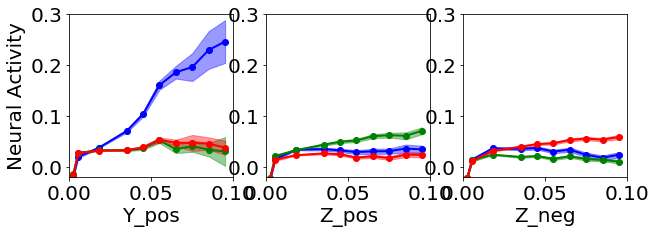

In [313]:
plt.figure(figsize=(10,3))
colors = {'scores_ypos_unique': 'blue', 'scores_zpos_unique': 'green', 'scores_zneg_unique': 'red'}

cnt = 0
for j, beh in enumerate(['Y_pos', 'Z_pos', 'Z_neg']):
    for k, neu in enumerate(['scores_ypos_unique', 'scores_zpos_unique', 'scores_zneg_unique']):
        cnt+=1
        plt.subplot(1,3,j+1)
        
        # make x bins, get mean y in each bin
        num_bins = 10
        xbins = np.linspace(0,.1,num_bins+1)
        xbins[1] = .005
        xbins[2] = .006
        avgs = []
        stds = []
        cnts = []
        for i in range(num_bins):
            start = xbins[i]
            end = xbins[i+1]
            a = np.where(np.logical_and(pooled_behavior[beh]>start, pooled_behavior[beh]<=end))
            avgs.append(np.mean(resp[neu][a]))
            stds.append(np.std(resp[neu][a]))
            cnts.append(len(a[0]))

        #step = xbins[1] - xbins[0]
        mids = [((xbins[i+1]-xbins[i])/2)+xbins[i] for i in range(len(xbins)-1)]
        #mids = [i+step/2 for i in xbins]
        #plt.scatter(pooled_behavior[beh],resp[neu],marker='.',color='k')
        color = colors[neu]
        plt.plot(mids,avgs,color=color,lw=2,marker='o')
        plt.fill_between(mids, 
                         [avgs[i] - stds[i]/np.sqrt(cnts[i]) for i in range(len(mids))],
                         [avgs[i] + stds[i]/np.sqrt(cnts[i]) for i in range(len(mids))],
                         alpha=0.4,
                         color=color)
        if j == 0:
            plt.ylabel('Neural Activity')
        plt.xlabel(beh)
        plt.ylim(-.02,.3)
        plt.xlim(0,.1)
        #plt.title()

        #r, p = scipy.stats.pearsonr(pooled_behavior[beh], resp[neu])
        #plt.title(F'{r:.2f}')
        
        # here, each plot shows one voxel type, and the 3 colors show its response to beh
        # now i've switched it! each plot shows 1 behavior

In [343]:
n_samples = 500
beh_sorted = np.argsort(pooled_behavior['Y_pos'])
n_bins = int(np.floor(len(pooled_behavior['Y_pos'])/n_samples))
avgs = []
for i in range(n_bins):
    avgs.append(np.mean(pooled_behavior['Y_pos'][beh_sorted[n_samples*i:n_samples*(i+1)]]))

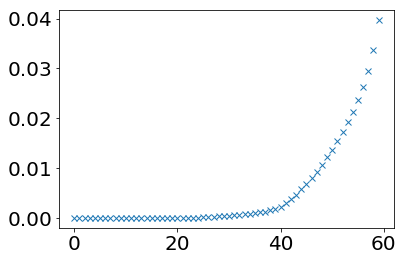

In [344]:
plt.plot(avgs,'x')

In [ ]:
#actually, final bin should just be catch all
# or what about bins with equal #samples?


In [324]:
a = np.percentile(pooled_behavior['Z_pos'], 99.9)
b = np.percentile(pooled_behavior['Z_neg'], 99.9)
np.mean([a,b])

0.13202081923359493

In [320]:
# this will be easier if I normalize behavior to max at something like 95% percentile

np.percentile(pooled_behavior['Y_pos'], 99.9)

0.07153370098019668

In [325]:
len(pooled_behavior['Y_pos'])

30456

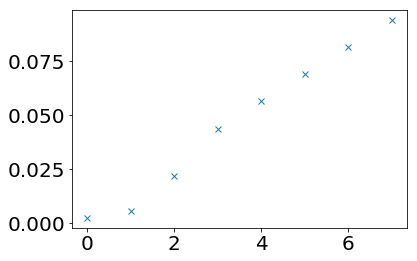

In [311]:
plt.plot(mids,'x')

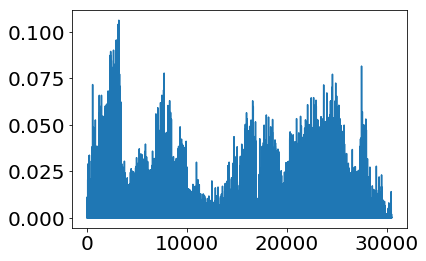

In [282]:
plt.plot(pooled_behavior['Y_pos'])

In [280]:
sphere_radius = 4.5e-3 # in m
fps=50
0.1 * sphere_radius * fps * 1000 ##mm/sec

22.5

In [281]:
0.1 * 180 / np.pi * fps ## deg/sec

286.4788975654116

In [190]:
r, p = scipy.stats.pearsonr(pooled_behavior['Y_pos'], fwd_resp)
r

0.2905808614136957

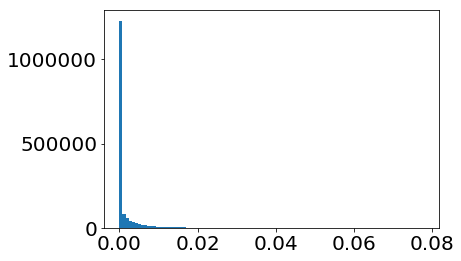

In [19]:
plt.hist(all_colored_by_betas_full[...,2].flatten(),bins=100);

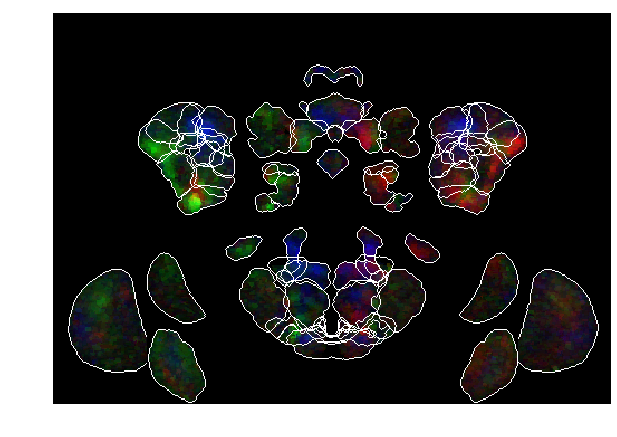

In [38]:
plt.figure(figsize=(10,10))
plt.imshow(canvas[150:,:])
plt.axis('off')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}_zneg_unique')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

In [2]:
fly_dir = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_094/func_0'
fictrac_raw = bbb.load_fictrac(os.path.join(fly_dir, 'fictrac'))


~~ load_fictrac ~~
load_fictrac done. Duration: 2.91 sec


In [3]:
out = np.asarray(fictrac_raw['dRotLabZ'])
out.shape

(90000,)

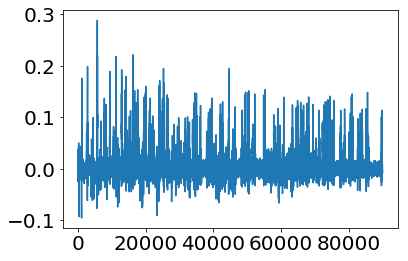

In [4]:
plt.plot(out)

In [5]:
1

1